In [2]:
import pandas as pd
import numpy as np
# import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn import preprocessing

seed = 42

FILENAME = "train_dataset.csv"

#Prepare train data
df1 = pd.read_csv(FILENAME, encoding='ISO-8859-1', sep=",", low_memory=False)
# print("EX1) #Righe: " + str(df1.shape[0])+ " #Colonne: "+str(df1.shape[1]))

# print(df1.nunique())
# print(df1.isna().sum())

# print(df1.shape)
df1 = df1.dropna()
# print(df1.shape)

In [ ]:
y = df1["type"]
X = df1.drop(columns=["type", "label"])

err_arr = X.loc[X["src_bytes"] == "0.0.0.0"]
X = X.drop(index=err_arr.index)
y = y.drop(index=err_arr.index)
X.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

X = X.to_numpy()
y = y.to_numpy()

# for feature in ["dns_AA","dns_RD","dns_RA","dns_rejected","ssl_version","ssl_cipher","ssl_resumed","ssl_established","ssl_subject","ssl_issuer","http_trans_depth","http_method","http_uri","http_referrer","http_version","http_request_body_len","http_response_body_len","http_status_code","http_user_agent","http_orig_mime_types","http_resp_mime_types","weird_name","weird_addl","weird_notice"]:
#     # print(f"Feature: {feature}")    
#     feature_index = np.where(df1.columns == feature)[0][0]
#     elements, counts = np.unique(X[:, feature_index], return_counts=True)

#     for element, count in zip(elements, counts):
#         print(f"    Element: {element}, Count: {count}")

TypeError: could not convert string to float: '192.168.1.152'

In [4]:
oe = preprocessing.OrdinalEncoder()
oe.fit(X)
X = oe.transform(X)

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

In [5]:
x_tomod = X

In [6]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(0.01)
x_tomod = selector.fit_transform(x_tomod)

In [7]:
print(x_tomod.shape, y.shape)

(616983, 28) (616983,)


In [8]:
X = x_tomod

In [9]:
train_idx, test_idx = train_test_split(np.arange(X.shape[0]), test_size=0.2, stratify=y, random_state=seed)
test_idx, val_idx = train_test_split(test_idx, test_size=0.5, stratify=y[test_idx], random_state=seed)

X_test = X[test_idx,:]
y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]

In [10]:
## Scaling
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## PCA
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

## LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
X_val_lda = lda.transform(X_val)

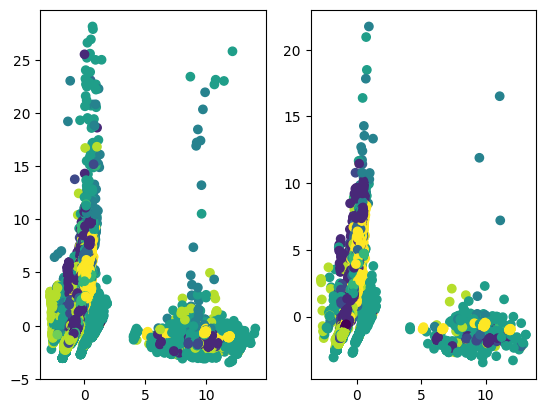

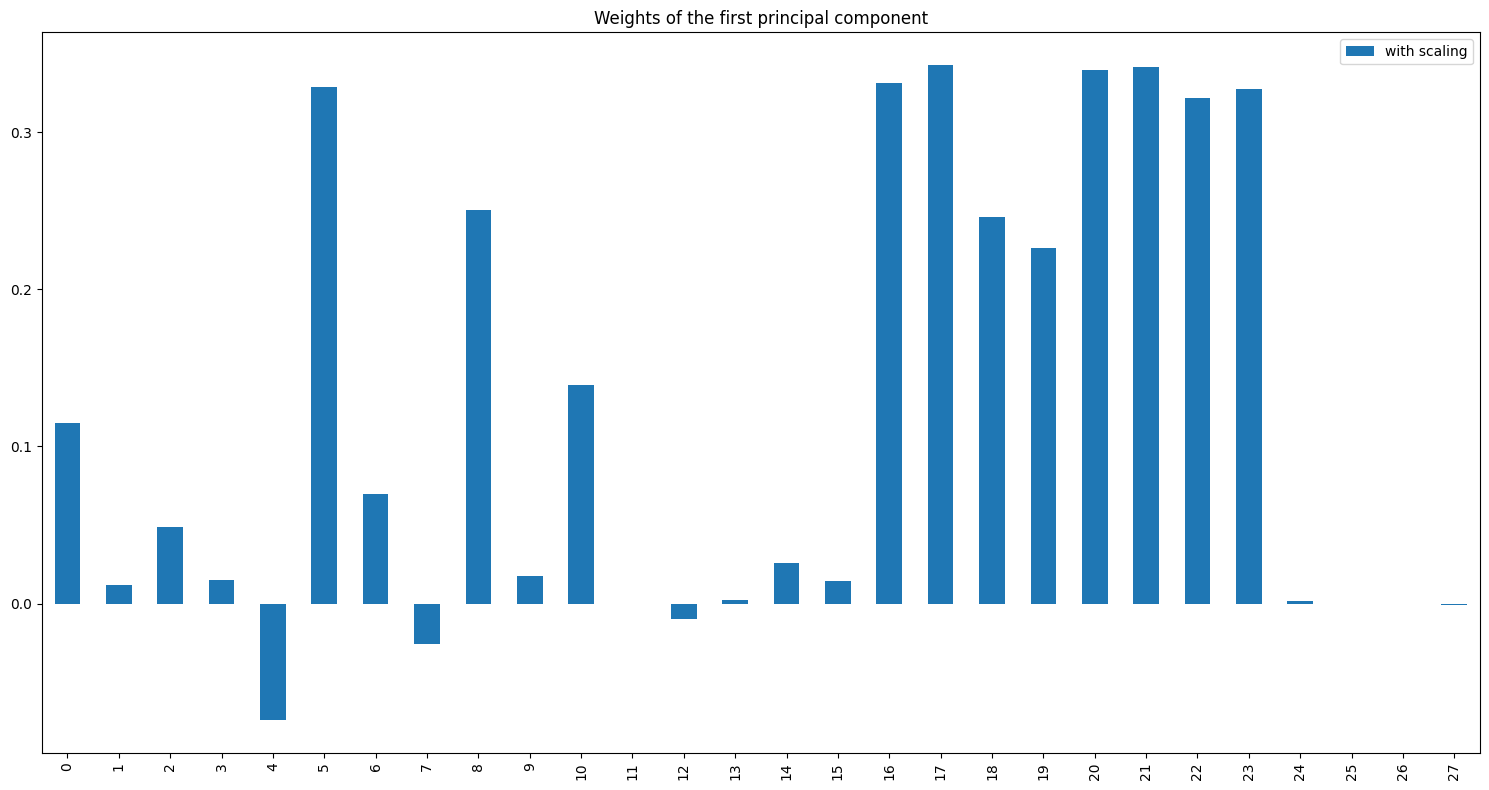

In [11]:
## PCA plotting
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)

axs[0].scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train)
axs[1].scatter(X_val_pca[:,0], X_val_pca[:,1], c=y_val)
plt.show()

first_pca_component = pd.DataFrame()
first_pca_component["with scaling"] = pca.components_[0]
first_pca_component.plot.bar(title="Weights of the first principal component", figsize=(15, 8))
_ = plt.tight_layout()

In [12]:
import pickle

file = pickle.load(open("knn.pkl", "rb"))

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score

---

In [14]:
## WITH PCA

list_clf_pca = []
list_acc_train_pca = []
list_rec_train_pca = []
list_pre_train_pca = []
list_f1_train_pca = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_pca, y_train)

    y_pred = clf.predict(X_test_pca)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train_pca.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train_pca.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train_pca.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train_pca.append(score_f1)

    score = clf.score(X_test_pca, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf_pca.append(clf)

K=10
  Accuracy - 0.9974
  F1 - 0.9974
K=20
  Accuracy - 0.9968
  F1 - 0.9968
K=50
  Accuracy - 0.9946
  F1 - 0.9946
K=100
  Accuracy - 0.9928
  F1 - 0.9927
K=500
  Accuracy - 0.9806
  F1 - 0.9801


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=775
  Accuracy - 0.9746
  F1 - 0.9735


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=900
  Accuracy - 0.9720
  F1 - 0.9708


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1000
  Accuracy - 0.9697
  F1 - 0.9683


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500
  Accuracy - 0.9641
  F1 - 0.9620


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2000
  Accuracy - 0.9534
  F1 - 0.9507


In [15]:

# file = pickle.load(open("knn_pca.pkl", "rb"))

# list_clf_pca = file[0]

list_acc_val_pca = []
list_rec_val_pca = []
list_pre_val_pca = []
list_f1_val_pca = []

for clf in list_clf_pca:
    val_pred = clf.predict(X_val_pca)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val_pca.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val_pca.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val_pca.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val_pca.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

10
  Accuracy - 0.9969
  F1 - 0.9969
20
  Accuracy - 0.9962
  F1 - 0.9962
50
  Accuracy - 0.9940
  F1 - 0.9940
100
  Accuracy - 0.9924
  F1 - 0.9923
500
  Accuracy - 0.9798
  F1 - 0.9792


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


775
  Accuracy - 0.9728
  F1 - 0.9716


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


900
  Accuracy - 0.9703
  F1 - 0.9690


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1000
  Accuracy - 0.9681
  F1 - 0.9666


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1500
  Accuracy - 0.9625
  F1 - 0.9603
2000
  Accuracy - 0.9521
  F1 - 0.9491


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---

In [16]:
list_clf_lda = []
list_acc_train_lda = []
list_rec_train_lda = []
list_pre_train_lda = []
list_f1_train_lda = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_lda, y_train)

    y_pred = clf.predict(X_test_lda)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train_pca.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train_pca.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train_pca.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train_pca.append(score_f1)

    score = clf.score(X_test_lda, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf_lda.append(clf)

K=10
  Accuracy - 0.9976
  F1 - 0.9975
K=20
  Accuracy - 0.9966
  F1 - 0.9966
K=50
  Accuracy - 0.9950
  F1 - 0.9949
K=100
  Accuracy - 0.9929
  F1 - 0.9928
K=500
  Accuracy - 0.9843
  F1 - 0.9839
K=775
  Accuracy - 0.9789
  F1 - 0.9783
K=900
  Accuracy - 0.9774
  F1 - 0.9765
K=1000
  Accuracy - 0.9762
  F1 - 0.9749


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500
  Accuracy - 0.9700
  F1 - 0.9680


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2000
  Accuracy - 0.9648
  F1 - 0.9625


In [17]:

# file = pickle.load(open("knn_pca.pkl", "rb"))

# list_clf_pca = file[0]

list_acc_val_lda = []
list_rec_val_lda = []
list_pre_val_lda = []
list_f1_val_lda = []

for clf in list_clf_lda:
    val_pred = clf.predict(X_val_lda)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val_pca.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val_pca.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val_pca.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val_pca.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

10
  Accuracy - 0.9973
  F1 - 0.9973
20
  Accuracy - 0.9961
  F1 - 0.9961
50
  Accuracy - 0.9944
  F1 - 0.9943
100
  Accuracy - 0.9923
  F1 - 0.9922
500
  Accuracy - 0.9825
  F1 - 0.9821
775
  Accuracy - 0.9777
  F1 - 0.9771
900
  Accuracy - 0.9759
  F1 - 0.9750
1000
  Accuracy - 0.9747
  F1 - 0.9733


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1500
  Accuracy - 0.9690
  F1 - 0.9668
2000
  Accuracy - 0.9635
  F1 - 0.9611


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---

In [18]:
list_clf = []
list_acc_train = []
list_rec_train = []
list_pre_train = []
list_f1_train = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train_pca.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train_pca.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train_pca.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train_pca.append(score_f1)

    score = clf.score(X_test, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf.append(clf)

K=10
  Accuracy - 0.9974
  F1 - 0.9974
K=20
  Accuracy - 0.9968
  F1 - 0.9968
K=50
  Accuracy - 0.9946
  F1 - 0.9946
K=100
  Accuracy - 0.9928
  F1 - 0.9927
K=500
  Accuracy - 0.9806
  F1 - 0.9801


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=775
  Accuracy - 0.9746
  F1 - 0.9735


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=900
  Accuracy - 0.9720
  F1 - 0.9708


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1000
  Accuracy - 0.9697
  F1 - 0.9683


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500
  Accuracy - 0.9641
  F1 - 0.9620


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2000
  Accuracy - 0.9534
  F1 - 0.9507


In [19]:

# file = pickle.load(open("knn_pca.pkl", "rb"))

# list_clf_pca = file[0]

list_acc_val = []
list_rec_val = []
list_pre_val = []
list_f1_val = []

for clf in list_clf:
    val_pred = clf.predict(X_val)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val_pca.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val_pca.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val_pca.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val_pca.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

10
  Accuracy - 0.9969
  F1 - 0.9969
20
  Accuracy - 0.9962
  F1 - 0.9962
50
  Accuracy - 0.9940
  F1 - 0.9940
100
  Accuracy - 0.9924
  F1 - 0.9923
500
  Accuracy - 0.9798
  F1 - 0.9792


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


775
  Accuracy - 0.9728
  F1 - 0.9716


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


900
  Accuracy - 0.9703
  F1 - 0.9690


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1000
  Accuracy - 0.9681
  F1 - 0.9666


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1500
  Accuracy - 0.9625
  F1 - 0.9603
2000
  Accuracy - 0.9521
  F1 - 0.9491


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
with open('knn_lda_red.pkl', 'wb') as f:
    pickle.dump([list_clf_lda, list_acc_train_lda, list_rec_train_lda, list_pre_train_lda, list_f1_train_lda, list_acc_val_lda, list_rec_val_lda, list_pre_val_lda, list_f1_val_lda], f)
with open('knn_pca_red.pkl', 'wb') as f:
    pickle.dump([list_clf_pca, list_acc_train_pca, list_rec_train_pca, list_pre_train_pca, list_f1_train_pca, list_acc_val_pca, list_rec_val_pca, list_pre_val_pca, list_f1_val_pca], f)
with open('knn_std_red.pkl', 'wb') as f:
    pickle.dump([list_clf, list_acc_train, list_rec_train, list_pre_train, list_f1_train, list_acc_val, list_rec_val, list_pre_val, list_f1_val], f)

---

---

In [21]:
seed = 42

FILENAME = "train_dataset.csv"

#Prepare train data
df1 = pd.read_csv(FILENAME, encoding='ISO-8859-1', sep=",", low_memory=False)
# print("EX1) #Righe: " + str(df1.shape[0])+ " #Colonne: "+str(df1.shape[1]))

# print(df1.nunique())
# print(df1.isna().sum())

# print(df1.shape)
df1 = df1.dropna()
# print(df1.shape)

y = df1["type"]
X = df1.drop(columns=["type", "label"])

err_arr = X.loc[X["src_bytes"] == "0.0.0.0"]
X = X.drop(index=err_arr.index)
y = y.drop(index=err_arr.index)
X.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

X = X.to_numpy()
y = y.to_numpy()

# for feature in ["dns_AA","dns_RD","dns_RA","dns_rejected","ssl_version","ssl_cipher","ssl_resumed","ssl_established","ssl_subject","ssl_issuer","http_trans_depth","http_method","http_uri","http_referrer","http_version","http_request_body_len","http_response_body_len","http_status_code","http_user_agent","http_orig_mime_types","http_resp_mime_types","weird_name","weird_addl","weird_notice"]:
#     # print(f"Feature: {feature}")    
#     feature_index = np.where(df1.columns == feature)[0][0]
#     elements, counts = np.unique(X[:, feature_index], return_counts=True)

    # for element, count in zip(elements, counts):
    #     print(f"    Element: {element}, Count: {count}")

In [22]:
oe = preprocessing.OrdinalEncoder()
oe.fit(X)
X = oe.transform(X)

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)


train_idx, test_idx = train_test_split(np.arange(X.shape[0]), test_size=0.2, stratify=y, random_state=seed)
test_idx, val_idx = train_test_split(test_idx, test_size=0.5, stratify=y[test_idx], random_state=seed)

X_test = X[test_idx,:]
y_test = y[test_idx]
X_train = X[train_idx,:]
y_train = y[train_idx]
X_val = X[val_idx,:]
y_val = y[val_idx]


## Scaling
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## PCA
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

## LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
X_val_lda = lda.transform(X_val)

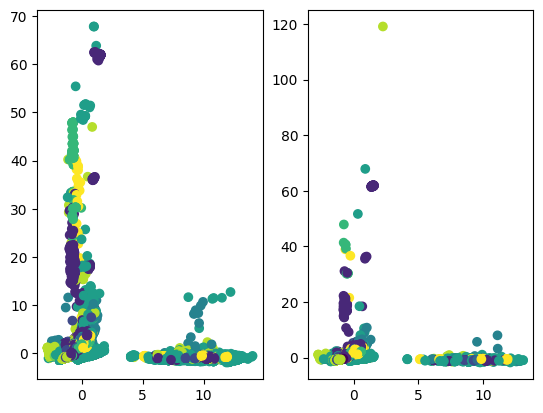

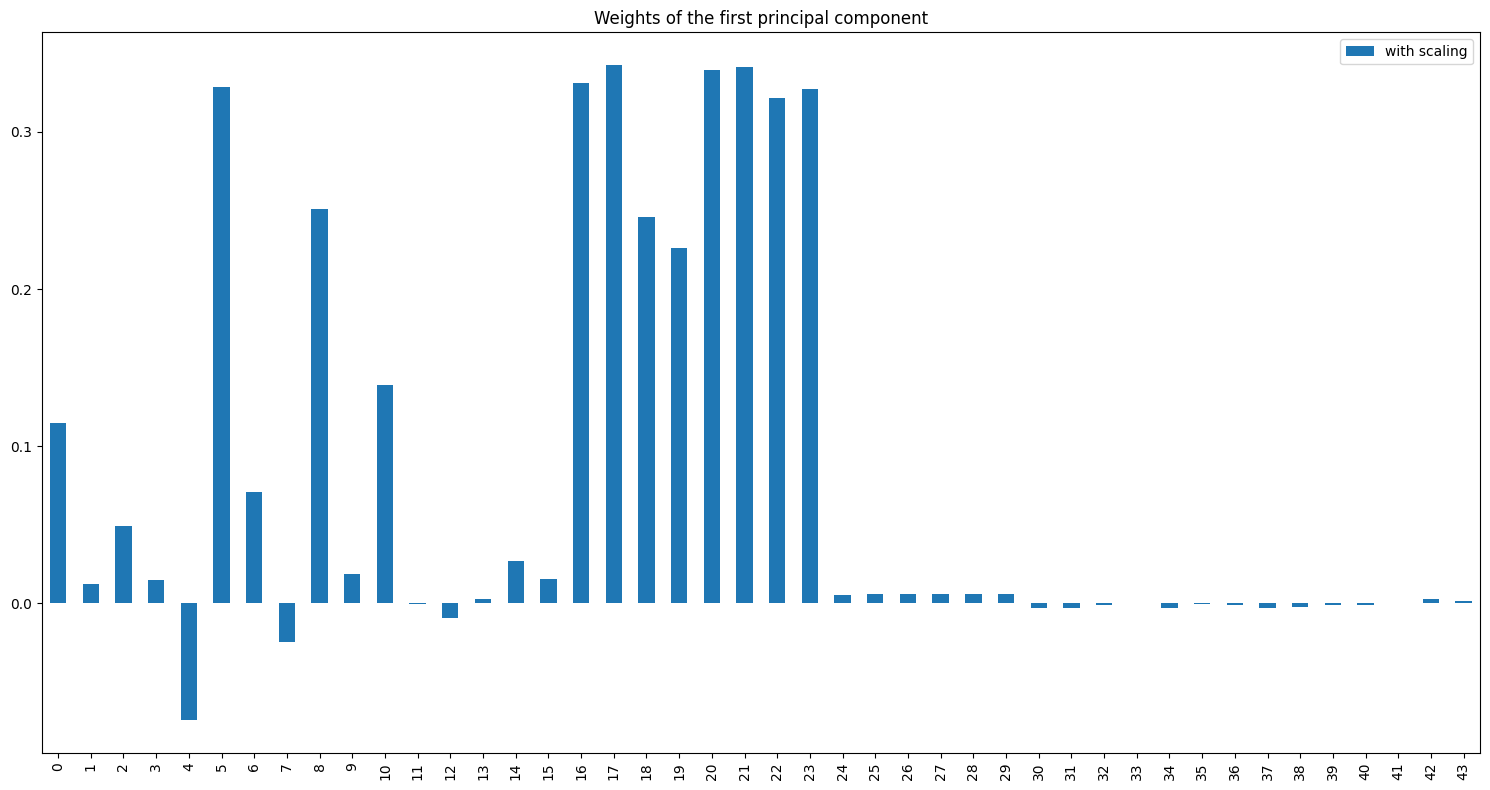

In [23]:
## PCA plotting
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)

axs[0].scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train)
axs[1].scatter(X_val_pca[:,0], X_val_pca[:,1], c=y_val)
plt.show()

first_pca_component = pd.DataFrame()
first_pca_component["with scaling"] = pca.components_[0]
first_pca_component.plot.bar(title="Weights of the first principal component", figsize=(15, 8))
_ = plt.tight_layout()

---

In [24]:
## WITH PCA

list_clf_pca = []
list_acc_train_pca = []
list_rec_train_pca = []
list_pre_train_pca = []
list_f1_train_pca = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_pca, y_train)

    y_pred = clf.predict(X_test_pca)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train_pca.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train_pca.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train_pca.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train_pca.append(score_f1)

    score = clf.score(X_test_pca, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf_pca.append(clf)

K=10
  Accuracy - 0.9974
  F1 - 0.9974
K=20
  Accuracy - 0.9968
  F1 - 0.9968
K=50
  Accuracy - 0.9946
  F1 - 0.9946
K=100
  Accuracy - 0.9927
  F1 - 0.9927
K=500
  Accuracy - 0.9806
  F1 - 0.9800


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=775
  Accuracy - 0.9743
  F1 - 0.9732


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=900
  Accuracy - 0.9719
  F1 - 0.9706


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1000
  Accuracy - 0.9697
  F1 - 0.9683


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500
  Accuracy - 0.9641
  F1 - 0.9620


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2000
  Accuracy - 0.9524
  F1 - 0.9494


In [25]:

# file = pickle.load(open("knn_pca.pkl", "rb"))

# list_clf_pca = file[0]

list_acc_val_pca = []
list_rec_val_pca = []
list_pre_val_pca = []
list_f1_val_pca = []

for clf in list_clf_pca:
    val_pred = clf.predict(X_val_pca)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val_pca.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val_pca.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val_pca.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val_pca.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

10
  Accuracy - 0.9969
  F1 - 0.9969
20
  Accuracy - 0.9962
  F1 - 0.9962
50
  Accuracy - 0.9940
  F1 - 0.9940
100
  Accuracy - 0.9924
  F1 - 0.9923
500
  Accuracy - 0.9797
  F1 - 0.9791


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


775
  Accuracy - 0.9726
  F1 - 0.9714


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


900
  Accuracy - 0.9702
  F1 - 0.9688


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1000
  Accuracy - 0.9681
  F1 - 0.9666


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1500
  Accuracy - 0.9624
  F1 - 0.9602
2000
  Accuracy - 0.9515
  F1 - 0.9483


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---

In [26]:
## WITH LDA

list_clf_lda = []
list_acc_train_lda = []
list_rec_train_lda = []
list_pre_train_lda = []
list_f1_train_lda = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_lda, y_train)

    y_pred = clf.predict(X_test_lda)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train_pca.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train_pca.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train_pca.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train_pca.append(score_f1)

    score = clf.score(X_test_lda, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf_lda.append(clf)

K=10
  Accuracy - 0.9975
  F1 - 0.9975
K=20
  Accuracy - 0.9966
  F1 - 0.9966
K=50
  Accuracy - 0.9950
  F1 - 0.9949
K=100
  Accuracy - 0.9929
  F1 - 0.9929
K=500
  Accuracy - 0.9843
  F1 - 0.9840
K=775
  Accuracy - 0.9788
  F1 - 0.9783
K=900
  Accuracy - 0.9774
  F1 - 0.9765
K=1000
  Accuracy - 0.9762
  F1 - 0.9749


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500
  Accuracy - 0.9701
  F1 - 0.9681


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2000
  Accuracy - 0.9648
  F1 - 0.9625


In [27]:

# file = pickle.load(open("knn_pca.pkl", "rb"))

# list_clf_pca = file[0]

list_acc_val_lda = []
list_rec_val_lda = []
list_pre_val_lda = []
list_f1_val_lda = []

for clf in list_clf_lda:
    val_pred = clf.predict(X_val_lda)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val_pca.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val_pca.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val_pca.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val_pca.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

10
  Accuracy - 0.9972
  F1 - 0.9972
20
  Accuracy - 0.9962
  F1 - 0.9962
50
  Accuracy - 0.9944
  F1 - 0.9944
100
  Accuracy - 0.9923
  F1 - 0.9923
500
  Accuracy - 0.9826
  F1 - 0.9822
775
  Accuracy - 0.9777
  F1 - 0.9771
900
  Accuracy - 0.9759
  F1 - 0.9750
1000
  Accuracy - 0.9747
  F1 - 0.9733


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1500
  Accuracy - 0.9689
  F1 - 0.9668
2000
  Accuracy - 0.9635
  F1 - 0.9610


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---

In [28]:
list_clf = []
list_acc_train = []
list_rec_train = []
list_pre_train = []
list_f1_train = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    score_acc = accuracy_score(y_test, y_pred)
    list_acc_train_pca.append(score_acc)
    score_recall = recall_score(y_test, y_pred, average='weighted')
    list_rec_train_pca.append(score_recall)
    score_precision = precision_score(y_test, y_pred, average='weighted')
    list_pre_train_pca.append(score_precision)
    score_f1 = f1_score(y_test, y_pred, average='weighted')
    list_f1_train_pca.append(score_f1)

    score = clf.score(X_test, y_test)

    print("K={:d}".format(k))
    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

    # if best_score < score:
    #     best_score = score
    #     best_k = k
    #     best_clf = clf
    
    list_clf.append(clf)

K=10
  Accuracy - 0.9974
  F1 - 0.9974
K=20
  Accuracy - 0.9968
  F1 - 0.9968
K=50
  Accuracy - 0.9946
  F1 - 0.9946
K=100
  Accuracy - 0.9927
  F1 - 0.9927
K=500
  Accuracy - 0.9806
  F1 - 0.9800


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=775
  Accuracy - 0.9743
  F1 - 0.9732


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=900
  Accuracy - 0.9719
  F1 - 0.9706


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1000
  Accuracy - 0.9697
  F1 - 0.9683


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=1500
  Accuracy - 0.9641
  F1 - 0.9620


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


K=2000
  Accuracy - 0.9524
  F1 - 0.9494


In [29]:

# file = pickle.load(open("knn_pca.pkl", "rb"))

# list_clf_pca = file[0]

list_acc_val = []
list_rec_val = []
list_pre_val = []
list_f1_val = []

for clf in list_clf:
    val_pred = clf.predict(X_val)

    score_acc = accuracy_score(y_val, val_pred)
    list_acc_val_pca.append(score_acc)
    score_recall = recall_score(y_val, val_pred, average='weighted')
    list_rec_val_pca.append(score_recall)
    score_precision = precision_score(y_val, val_pred, average='weighted')
    list_pre_val_pca.append(score_precision)
    score_f1 = f1_score(y_val, val_pred, average='weighted')
    list_f1_val_pca.append(score_f1)

    print(clf.n_neighbors)

    print("  Accuracy - {:.4f}".format(score_acc))
    # print("  Precision - {:.4f}".format(score_precision))
    # print("  Recall - {:.4f}".format(score_recall))
    print("  F1 - {:.4f}".format(score_f1))

10
  Accuracy - 0.9969
  F1 - 0.9969
20
  Accuracy - 0.9962
  F1 - 0.9962
50
  Accuracy - 0.9940
  F1 - 0.9940
100
  Accuracy - 0.9924
  F1 - 0.9923
500
  Accuracy - 0.9797
  F1 - 0.9791


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


775
  Accuracy - 0.9726
  F1 - 0.9714


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


900
  Accuracy - 0.9702
  F1 - 0.9688


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1000
  Accuracy - 0.9681
  F1 - 0.9666


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1500
  Accuracy - 0.9624
  F1 - 0.9602
2000
  Accuracy - 0.9515
  F1 - 0.9483


/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


---

In [30]:
with open('knn_lda_1.pkl', 'wb') as f:
    pickle.dump([list_clf_lda, list_acc_train_lda, list_rec_train_lda, list_pre_train_lda, list_f1_train_lda, list_acc_val_lda, list_rec_val_lda, list_pre_val_lda, list_f1_val_lda], f)
with open('knn_pca_1.pkl', 'wb') as f:
    pickle.dump([list_clf_pca, list_acc_train_pca, list_rec_train_pca, list_pre_train_pca, list_f1_train_pca, list_acc_val_pca, list_rec_val_pca, list_pre_val_pca, list_f1_val_pca], f)
with open('knn_std_1.pkl', 'wb') as f:
    pickle.dump([list_clf, list_acc_train, list_rec_train, list_pre_train, list_f1_train, list_acc_val, list_rec_val, list_pre_val, list_f1_val], f)

---

In [23]:
import pickle
import matplotlib.pyplot as plt

[0.9974071946756463, 0.996752295991901, 0.9945598259120566, 0.9926629280963499, 0.9800457143987409, 0.9731736750998905, 0.9706279940547888, 0.9682977236399392, 0.9620190954633612, 0.9494148719744465]
[0.9974071946756463, 0.996752295991901, 0.9945598259120566, 0.9926629280963499, 0.9800457143987409, 0.9731736750998905, 0.9706279940547888, 0.9682977236399392, 0.9620190954633612, 0.9494148719744465]
[0.9975172409174788, 0.996619058385513, 0.9949347913647788, 0.9928596913936699, 0.9839667009648496, 0.9782946001265572, 0.9765056395029627, 0.9749103030352204, 0.9680506836308314, 0.9624780277354115]
[0.9969082701487718, 0.996214879330659, 0.9940031037015103, 0.9922952574520529, 0.9791194959401491, 0.9713676490083517, 0.9688481094729537, 0.9666076737406929, 0.9602265240782123, 0.9483322146804776]
[0.9969082701487718, 0.996214879330659, 0.9940031037015103, 0.9922952574520529, 0.9791194959401491, 0.9713676490083517, 0.9688481094729537, 0.9666076737406929, 0.9602265240782123, 0.9483322146804776]


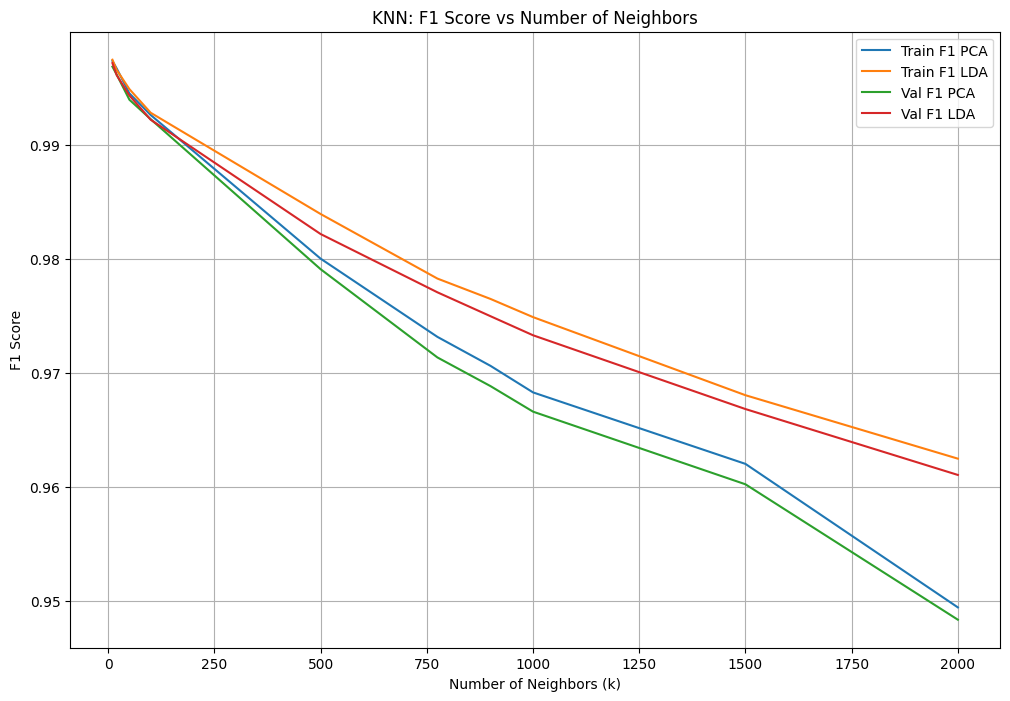

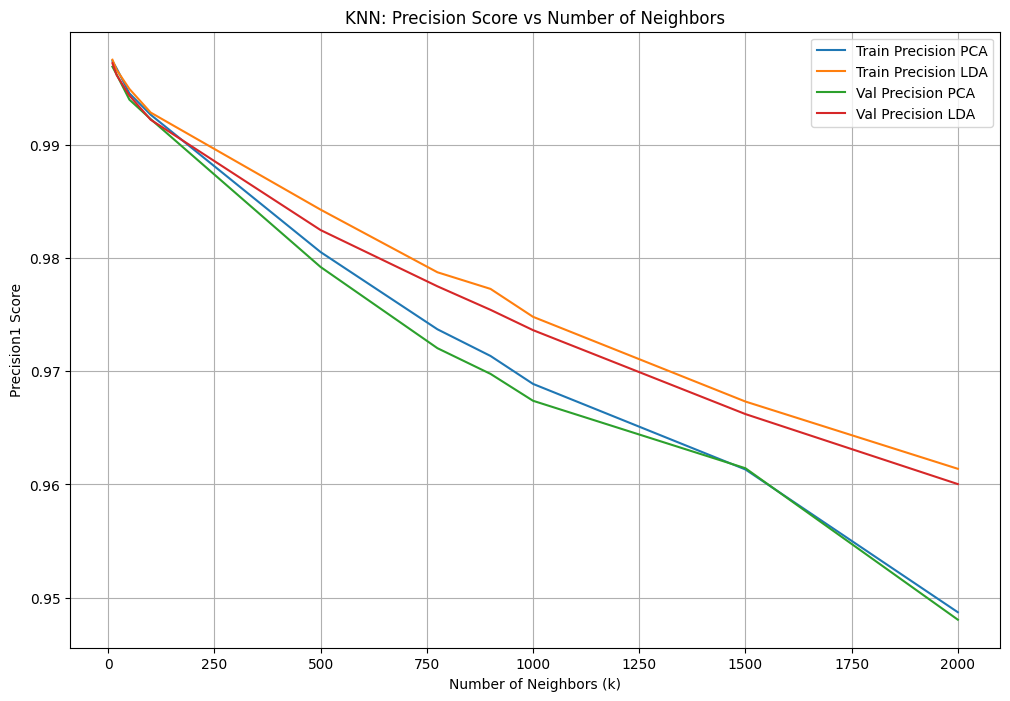

In [53]:
with open('knn_pca_1.pkl', 'rb') as f:
    data = pickle.load(f)

_, accuracy_train, recall_train, precision_train, f1_train, accuracy_val, recall_val, precision_val, f1_val = data

accuracy_train_pca = accuracy_train[:10]   
accuracy_train_lda = accuracy_train[10:20]
accuracy_train_nul = accuracy_train[20:]

recall_train_pca = recall_train[:10]   
recall_train_lda = recall_train[10:20]
recall_train_nul = recall_train[20:]

precision_train_pca = precision_train[:10]
precision_train_lda = precision_train[10:20]
precision_train_nul = precision_train[20:]

f1_train_pca = f1_train[:10]
f1_train_lda = f1_train[10:20]
f1_train_nul = f1_train[20:]

accuracy_val_pca = accuracy_val[:10]
accuracy_val_lda = accuracy_val[10:20]
accuracy_val_nul = accuracy_val[20:]

recall_val_pca = recall_val[:10]   
recall_val_lda = recall_val[10:20]
recall_val_nul = recall_val[20:]

precision_val_pca = precision_val[:10]
precision_val_lda = precision_val[10:20]
precision_val_nul = precision_val[20:]

f1_val_pca = f1_val[:10]
f1_val_lda = f1_val[10:20]
f1_val_nul = f1_val[20:]

print(f1_train_pca)
print(f1_train_nul)
print(f1_train_lda)
print(f1_val_pca)
print(f1_val_nul)
print(f1_val_lda)

plt.figure(figsize=(12, 8))
plt.plot([10,20,50,100,500,775,900,1000,1500,2000], f1_train_pca, label='Train F1 PCA')
plt.plot([10,20,50,100,500,775,900,1000,1500,2000], f1_train_lda, label='Train F1 LDA')
plt.plot([10,20,50,100,500,775,900,1000,1500,2000], f1_val_pca, label='Val F1 PCA')
plt.plot([10,20,50,100,500,775,900,1000,1500,2000], f1_val_lda, label='Val F1 LDA')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('F1 Score')
plt.title('KNN: F1 Score vs Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot([10,20,50,100,500,775,900,1000,1500,2000], precision_train_pca, label='Train Precision PCA')
plt.plot([10,20,50,100,500,775,900,1000,1500,2000], precision_train_lda, label='Train Precision LDA')
plt.plot([10,20,50,100,500,775,900,1000,1500,2000], precision_val_pca, label='Val Precision PCA')
plt.plot([10,20,50,100,500,775,900,1000,1500,2000], precision_val_lda, label='Val Precision LDA')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Precision1 Score')
plt.title('KNN: Precision Score vs Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()

# print(accuracy_train_pca)
# print(accuracy_train_nul)
# print(recall_train_nul)
# print(recall_train_pca)

# print(accuracy_train_lda)
# print(recall_train_lda)

# print(accuracy_val_pca)
# print(recall_val_nul)
# print(accuracy_val_nul)
# print(recall_val_pca)

# print(recall_val_lda)
# print(accuracy_val_lda)

# plt.figure(figsize=(12, 8))

# plt.plot([10,20,50,100,500,775,900,1000,1500,2000], accuracy_train_pca, label='Train Accuracy PCA')
# plt.plot([10,20,50,100,500,775,900,1000,1500,2000], accuracy_train_lda, label='Train Accuracy LDA')
# plt.plot([10,20,50,100,500,775,900,1000,1500,2000], accuracy_train_nul, label='Train Accuracy No Reduction')
# plt.plot([10,20,50,100,500,775,900,1000,1500,2000], accuracy_val_pca, label='Validation Accuracy PCA')
# plt.plot([10,20,50,100,500,775,900,1000,1500,2000], accuracy_val_lda, label='Validation Accuracy LDA')
# plt.plot([10,20,50,100,500,775,900,1000,1500,2000], accuracy_val_nul, label='Validation Accuracy No Reduction')

# plt.xlabel('Number of Neighbors (k)')
# plt.ylabel('Accuracy')
# plt.title('KNN: Accuracy vs Number of Neighbors')
# plt.legend()
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(12, 8))

# plt.plot([10,20,50,100,500,775,900,1000,1500,2000], recall_train_pca, label='Train Recall PCA', linestyle='--')
# plt.plot([10,20,50,100,500,775,900,1000,1500,2000], recall_train_lda, label='Train Recall LDA', linestyle='--')
# plt.plot([10,20,50,100,500,775,900,1000,1500,2000], recall_train_nul, label='Train Recall No Reduction', linestyle='--')
# plt.plot([10,20,50,100,500,775,900,1000,1500,2000], recall_val_pca, label='Validation Recall PCA', linestyle='--')
# plt.plot([10,20,50,100,500,775,900,1000,1500,2000], recall_val_lda, label='Validation Recall LDA', linestyle='--')
# plt.plot([10,20,50,100,500,775,900,1000,1500,2000], recall_val_nul, label='Validation Recall No Reduction', linestyle='--')

# plt.xlabel('Number of Neighbors (k)')
# plt.ylabel('Recall')
# plt.title('KNN: Recall vs Number of Neighbors')
# plt.legend()

# plt.grid(True)
# plt.show()

---
---
---

In [ ]:
import pandas as pd
import numpy as np
# import torch
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn import preprocessing

seed = 3

FILENAME = "train_dataset.csv"

#Prepare train data
df1 = pd.read_csv(FILENAME, encoding='ISO-8859-1', sep=",", low_memory=False)
# print("EX1) #Righe: " + str(df1.shape[0])+ " #Colonne: "+str(df1.shape[1]))

# print(df1.nunique())
# print(df1.isna().sum())

# print(df1.shape)
df1 = df1.dropna()
# print(df1.shape)


y = df1["type"]
X = df1.drop(columns=["type", "label"])

err_arr = X.loc[X["src_bytes"] == "0.0.0.0"]
X = X.drop(index=err_arr.index)
y = y.drop(index=err_arr.index)
X.astype({'src_bytes': 'int64', 'ts': 'datetime64[ms]', 'dns_AA': 'bool', 'dns_RD': 'bool', 'dns_RA': 'bool', 'dns_rejected': 'bool', 'ssl_resumed': 'bool', 'ssl_established': 'bool', 'weird_notice': 'bool'}).dtypes

X = X.to_numpy()
y = y.to_numpy()

for feature in ["dns_AA","dns_RD","dns_RA","dns_rejected","ssl_version","ssl_cipher","ssl_resumed","ssl_established","ssl_subject","ssl_issuer","http_trans_depth","http_method","http_uri","http_referrer","http_version","http_request_body_len","http_response_body_len","http_status_code","http_user_agent","http_orig_mime_types","http_resp_mime_types","weird_name","weird_addl","weird_notice"]:
    # print(f"Feature: {feature}")    
    feature_index = np.where(df1.columns == feature)[0][0]
    elements, counts = np.unique(X[:, feature_index], return_counts=True)

    # for element, count in zip(elements, counts):
    #     print(f"    Element: {element}, Count: {count}")


oe = preprocessing.OrdinalEncoder()
oe.fit(X)
X = oe.transform(X)

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)


# variances = np.var(X, axis=0)
# features = df1.columns
# for i, variance in enumerate(variances):
#     print(f"{features[i]} \t\t: Variance = {variance}")


from sklearn.feature_selection import VarianceThreshold

# selector = VarianceThreshold(0.01)
selector = VarianceThreshold(10000)

X_mod = selector.fit_transform(X)

print(f"Original shape: {X.shape}")
print(f"Modified shape: {X_mod.shape}")


train_idx, test_idx = train_test_split(np.arange(X_mod.shape[0]), test_size=0.2, stratify=y, random_state=seed)
test_idx, val_idx = train_test_split(test_idx, test_size=0.5, stratify=y[test_idx], random_state=seed)

y_test = y[test_idx]
y_train = y[train_idx]
y_val = y[val_idx]

X_test_mod = X_mod[test_idx,:]
X_train_mod = X_mod[train_idx,:]
X_val_mod = X_mod[val_idx,:]

X_test = X[test_idx,:]
X_train = X[train_idx,:]
X_val = X[val_idx,:]

print(X_train.shape, X_test.shape, X_val.shape)
print(X_train_mod.shape, X_test_mod.shape, X_val_mod.shape)
print(len(y_train), len(y_test), len(y_val))


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import decomposition

## Scaling (treshold)
scaler = preprocessing.StandardScaler()
scaler.fit(X_train_mod)
X_train_mod = scaler.transform(X_train_mod)
X_test_mod = scaler.transform(X_test_mod)
X_val_mod = scaler.transform(X_val_mod)

## Scaling (no treshold)
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

print(X_train.shape, X_test.shape, X_val.shape)
print(X_train_mod.shape, X_test_mod.shape, X_val_mod.shape)


## PCA (treshold)
pca = decomposition.PCA()
pca.fit(X_train_mod)
X_train_mod_pca = pca.transform(X_train_mod)
X_test_mod_pca = pca.transform(X_test_mod)
X_val_mod_pca = pca.transform(X_val_mod)

## PCA (no treshold)
pca = decomposition.PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
X_val_pca = pca.transform(X_val)

print(X_train_pca.shape, X_test_pca.shape, X_val_pca.shape)
print(X_train_mod_pca.shape, X_test_mod_pca.shape, X_val_mod_pca.shape)


## LDA (treshold)
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(X_train_mod, y_train)
X_train_mod_lda = lda.transform(X_train_mod)
X_test_mod_lda = lda.transform(X_test_mod)
X_val_mod_lda = lda.transform(X_val_mod)

## LDA (no treshold)
lda = LinearDiscriminantAnalysis(n_components=9)
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)
X_val_lda = lda.transform(X_val)

X_train_std = X_train
X_test_std = X_test
X_val_std = X_val

print(X_train_lda.shape, X_test_lda.shape, X_val_lda.shape)
print(X_train_mod_lda.shape, X_test_mod_lda.shape, X_val_mod_lda.shape)

Original shape: (616983, 44)
Modified shape: (616983, 10)
(493586, 44) (61698, 44) (61699, 44)
(493586, 10) (61698, 10) (61699, 10)
493586 61698 61699
(493586, 44) (61698, 44) (61699, 44)
(493586, 10) (61698, 10) (61699, 10)
(493586, 44) (61698, 44) (61699, 44)
(493586, 10) (61698, 10) (61699, 10)
(493586, 9) (61698, 9) (61699, 9)
(493586, 9) (61698, 9) (61699, 9)


: 

In [2]:
arr_clf = []
arr_y_pred = []
arr_y_pred_val = []

In [3]:
from sklearn.neighbors import KNeighborsClassifier

In [4]:
## PCA, treshold
X_train = X_train_mod_pca
X_test = X_test_mod_pca
X_val = X_val_mod_pca

list_clf = []
list_y_pred = []
list_y_pred_val = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf_in = KNeighborsClassifier(n_neighbors=k)
    clf_in.fit(X_train, y_train)

    print("K={:d}".format(k))

    y_pred = clf_in.predict(X_test)
    
    list_y_pred.append(y_pred)
    list_clf.append(clf_in)


    y_pred_val = clf_in.predict(X_val)

    list_y_pred_val.append(y_pred_val)

arr_clf.append(list_clf)
arr_y_pred.append(list_y_pred)
arr_y_pred_val.append(list_y_pred_val)

K=10
K=20
K=50
K=100
K=500
K=775
K=900
K=1000
K=1500
K=2000


In [5]:
## PCA, no treshold
X_train = X_train_pca
X_test = X_test_pca
X_val = X_val_pca

list_clf = []
list_y_pred = []
list_y_pred_val = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf_in = KNeighborsClassifier(n_neighbors=k)
    clf_in.fit(X_train, y_train)

    print("K={:d}".format(k))

    y_pred = clf_in.predict(X_test)
    
    list_y_pred.append(y_pred)
    list_clf.append(clf_in)


    y_pred_val = clf_in.predict(X_val)

    list_y_pred_val.append(y_pred_val)

arr_clf.append(list_clf)
arr_y_pred.append(list_y_pred)
arr_y_pred_val.append(list_y_pred_val)

K=10
K=20
K=50
K=100
K=500
K=775
K=900
K=1000
K=1500
K=2000


In [6]:
## LDA, treshold
X_train = X_train_mod_lda
X_test = X_test_mod_lda
X_val = X_val_mod_lda

list_clf = []
list_y_pred = []
list_y_pred_val = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf_in = KNeighborsClassifier(n_neighbors=k)
    clf_in.fit(X_train, y_train)

    print("K={:d}".format(k))

    y_pred = clf_in.predict(X_test)
    
    list_y_pred.append(y_pred)
    list_clf.append(clf_in)


    y_pred_val = clf_in.predict(X_val)

    list_y_pred_val.append(y_pred_val)

arr_clf.append(list_clf)
arr_y_pred.append(list_y_pred)
arr_y_pred_val.append(list_y_pred_val)

K=10
K=20
K=50
K=100
K=500
K=775
K=900
K=1000
K=1500
K=2000


In [7]:
## LDA, no treshold
X_train = X_train_lda
X_test = X_test_lda
X_val = X_val_lda

list_clf = []
list_y_pred = []
list_y_pred_val = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf_in = KNeighborsClassifier(n_neighbors=k)
    clf_in.fit(X_train, y_train)

    print("K={:d}".format(k))

    y_pred = clf_in.predict(X_test)
    
    list_y_pred.append(y_pred)
    list_clf.append(clf_in)


    y_pred_val = clf_in.predict(X_val)

    list_y_pred_val.append(y_pred_val)

arr_clf.append(list_clf)
arr_y_pred.append(list_y_pred)
arr_y_pred_val.append(list_y_pred_val)

K=10
K=20
K=50
K=100
K=500
K=775
K=900
K=1000
K=1500
K=2000


In [8]:
## no preprocess, treshold
X_train = X_train_mod
X_test = X_test_mod
X_val = X_val_mod

list_clf = []
list_y_pred = []
list_y_pred_val = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf_in = KNeighborsClassifier(n_neighbors=k)
    clf_in.fit(X_train, y_train)

    print("K={:d}".format(k))

    y_pred = clf_in.predict(X_test)
    
    list_y_pred.append(y_pred)
    list_clf.append(clf_in)


    y_pred_val = clf_in.predict(X_val)

    list_y_pred_val.append(y_pred_val)

arr_clf.append(list_clf)
arr_y_pred.append(list_y_pred)
arr_y_pred_val.append(list_y_pred_val)

K=10
K=20
K=50
K=100
K=500
K=775
K=900
K=1000
K=1500
K=2000


In [9]:
## no preprocess, no treshold
X_train = X_train_std
X_test = X_test_std
X_val = X_val_std

list_clf = []
list_y_pred = []
list_y_pred_val = []

for k in [10,20,50,100,500,775,900,1000,1500,2000]:
    clf_in = KNeighborsClassifier(n_neighbors=k)
    clf_in.fit(X_train, y_train)

    print("K={:d}".format(k))

    y_pred = clf_in.predict(X_test)
    
    list_y_pred.append(y_pred)
    list_clf.append(clf_in)


    y_pred_val = clf_in.predict(X_val)

    list_y_pred_val.append(y_pred_val)

arr_clf.append(list_clf)
arr_y_pred.append(list_y_pred)
arr_y_pred_val.append(list_y_pred_val)

K=10
K=20
K=50
K=100
K=500
K=775
K=900
K=1000
K=1500
K=2000


In [10]:
import pickle

with open("knn_cleaning_final.pkl", "wb") as file:
    pickle.dump([arr_clf, arr_y_pred, arr_y_pred_val], file)


pd.DataFrame(arr_y_pred_val).to_csv()

',0,1,2,3,4,5,6,7,8,9\n0,[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9]\n1,[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9]\n2,[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9]\n3,[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9]\n4,[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9]\n5,[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1 ... 9 8 9],[8 6 1

In [71]:
arr_clf, arr_y_pred, arr_y_pred_val = pickle.load(open("knn_cleaning_final.pkl", "rb"))

from sklearn.metrics import balanced_accuracy_score, f1_score

In [73]:
df_y_pred_val = pd.DataFrame(arr_y_pred_val, columns=[10,20,50,100,500,775,900,1000,1500,2000])

acc = []
f1 = []
for i in range(6):
    y_pred_arr = df_y_pred_val.iloc[i]
    acc_score = []
    arr_f1_score = []
    for j in range(10):
        tmp = y_pred_arr.iloc[j]
        acc_score.append(balanced_accuracy_score(y_val, tmp))
        arr_f1_score.append(f1_score(y_val, tmp, average='weighted'))
    print(acc_score)
    print(arr_f1_score)
    acc.append(np.max(acc_score))
    acc.append(acc_score.index(np.max(acc_score)))
    f1.append(np.max(arr_f1_score))
    f1.append(arr_f1_score.index(np.max(arr_f1_score)))

print(acc)
print(f1)


[np.float64(0.9670352254007092), np.float64(0.9615534994839028), np.float64(0.939045853361004), np.float64(0.9119038926593763), np.float64(0.8206680587227131), np.float64(0.7705536251206608), np.float64(0.7635669668350582), np.float64(0.7556772255589227), np.float64(0.7358151845210774), np.float64(0.7157569234612883)]
[0.996892334073049, 0.9961826170099302, 0.9940040965236223, 0.9922953817045097, 0.9791672840208286, 0.9715789114553602, 0.9689652416649249, 0.9666088224137784, 0.9602853782546111, 0.9490754314145916]
[np.float64(0.9670510306796724), np.float64(0.9616212970742062), np.float64(0.9390132559294155), np.float64(0.9119720506095648), np.float64(0.8206412939391197), np.float64(0.7703189964121132), np.float64(0.7634161099734326), np.float64(0.7556875510855706), np.float64(0.735669976389422), np.float64(0.7139800281192871)]
[0.9969082701487718, 0.996214879330659, 0.9940031037015103, 0.9922952574520529, 0.9791194959401491, 0.9713676490083517, 0.9688481094729537, 0.9666076737406929, 

/Users/filippobrajucha/Developer/data-analytics/.env/lib/python3.12/site-packages/sklearn/metrics/_plot/confusion_matrix.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


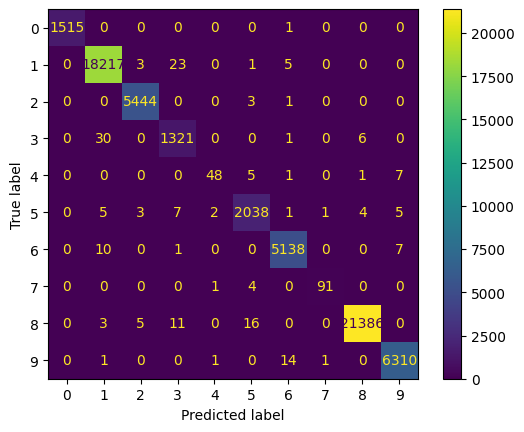

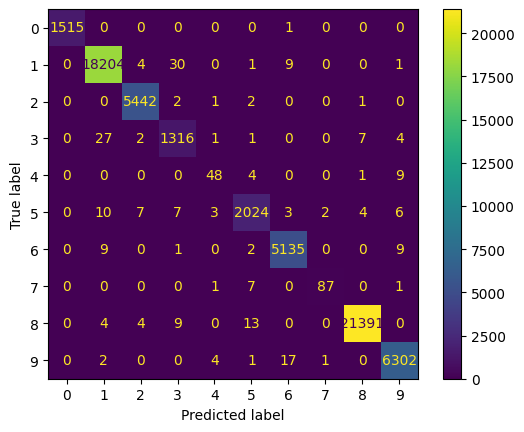

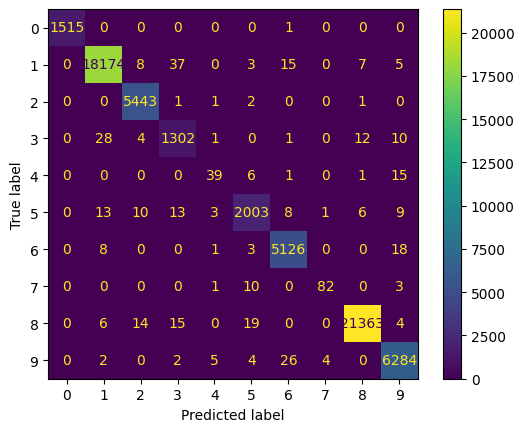

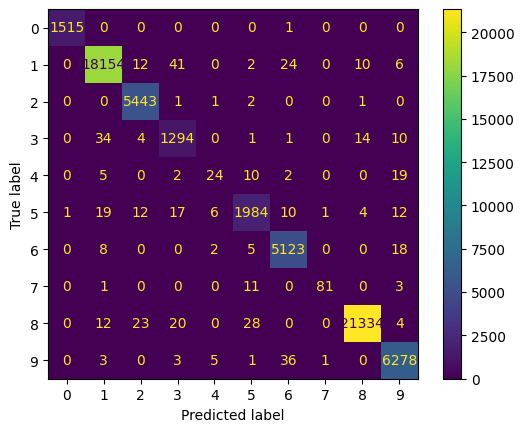

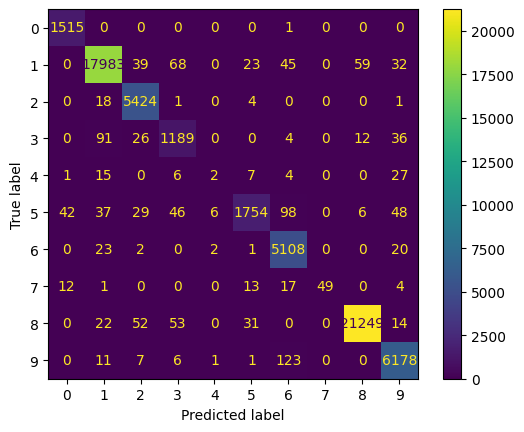

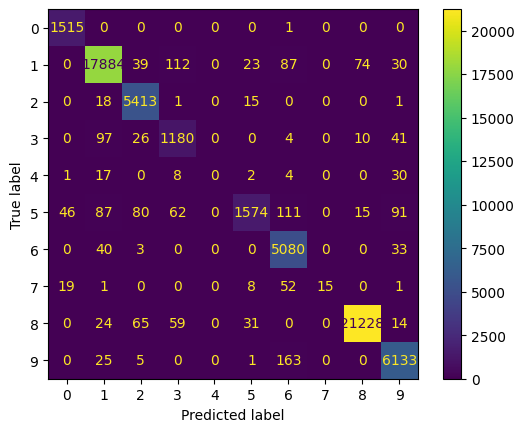

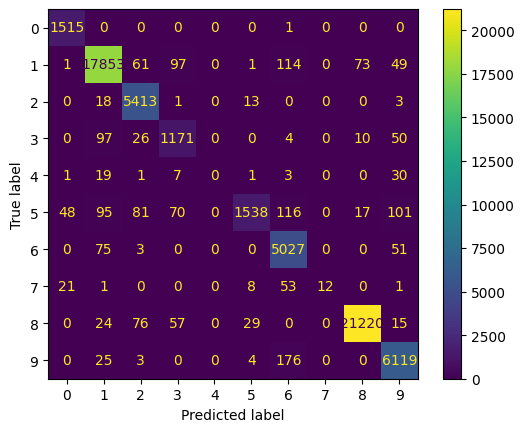

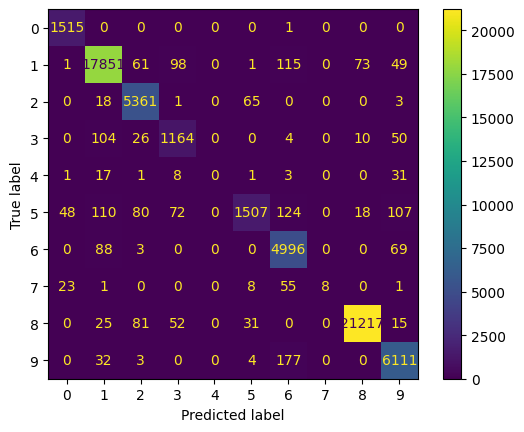

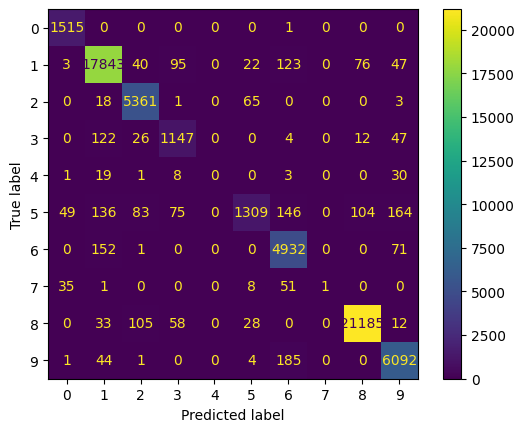

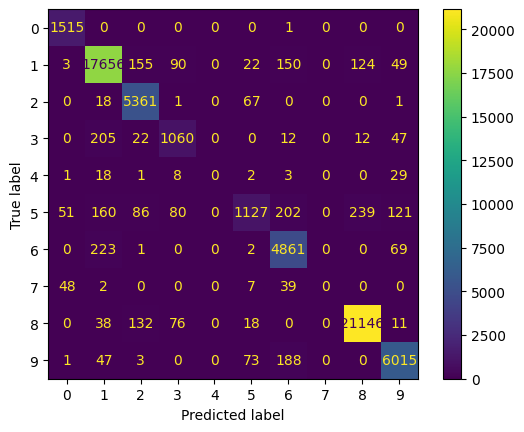

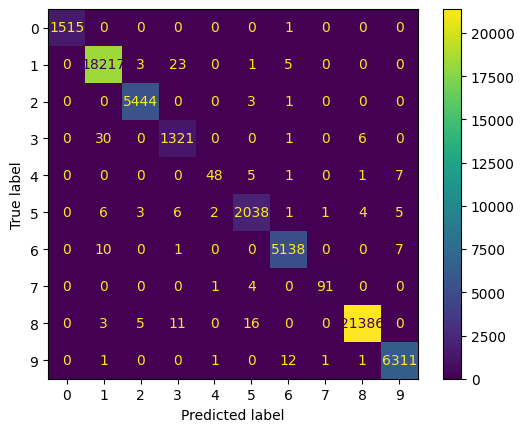

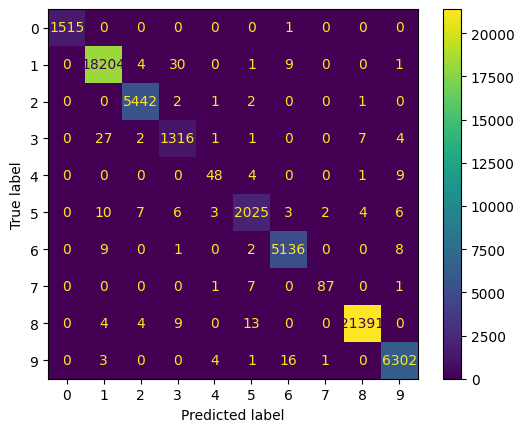

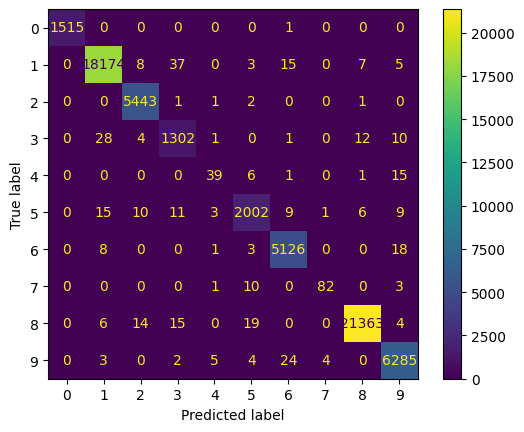

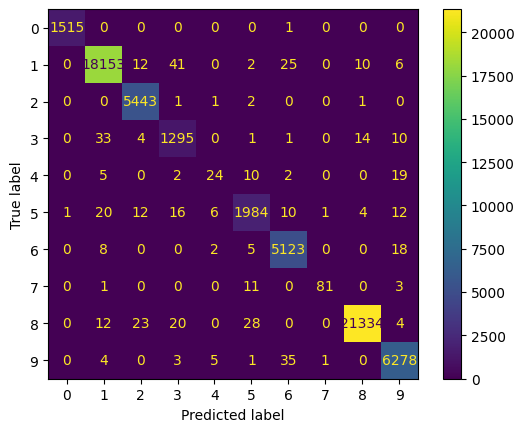

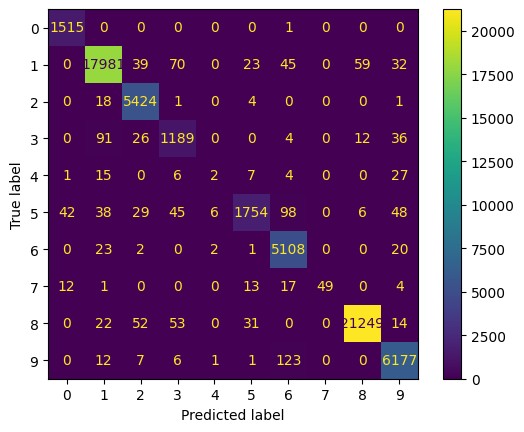

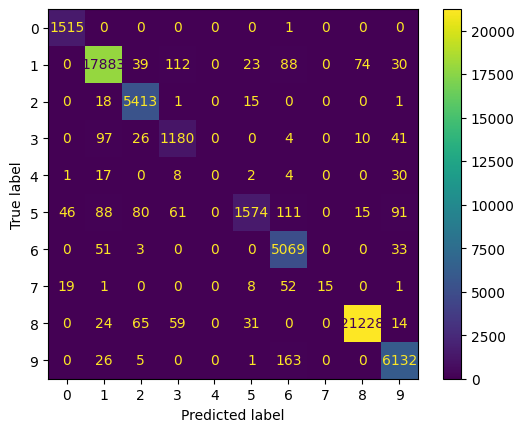

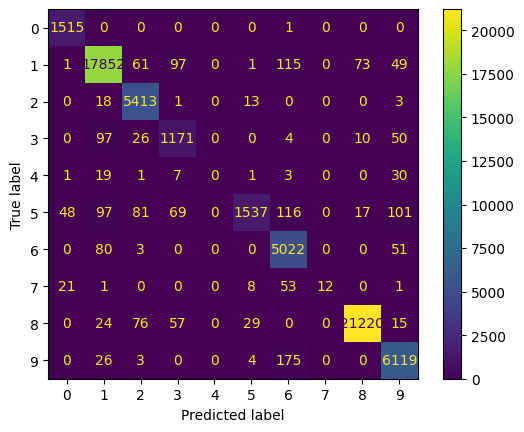

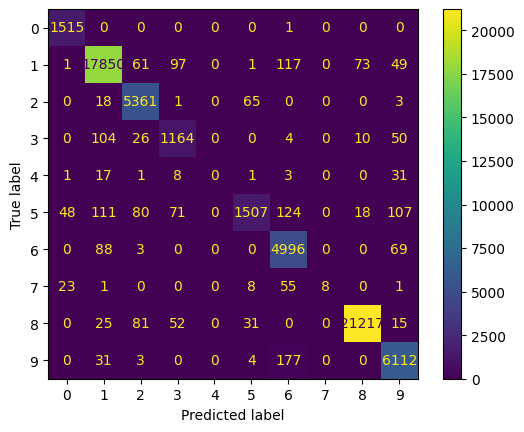

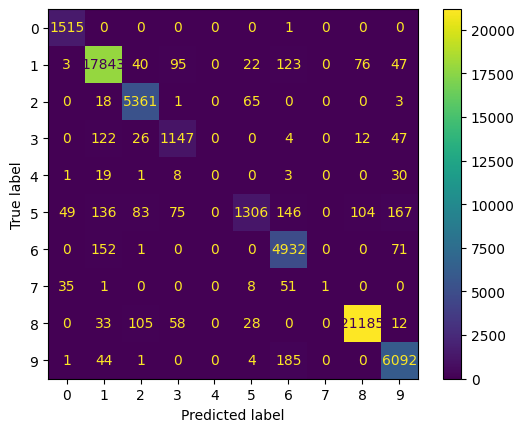

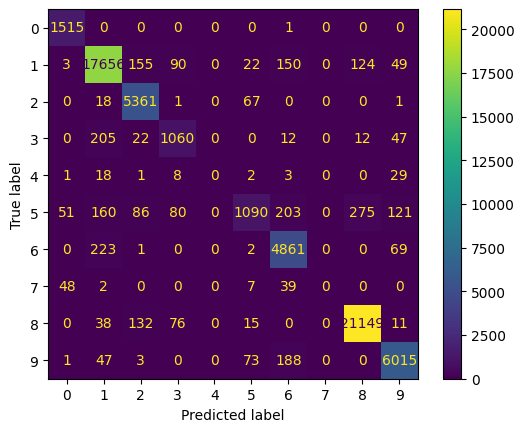

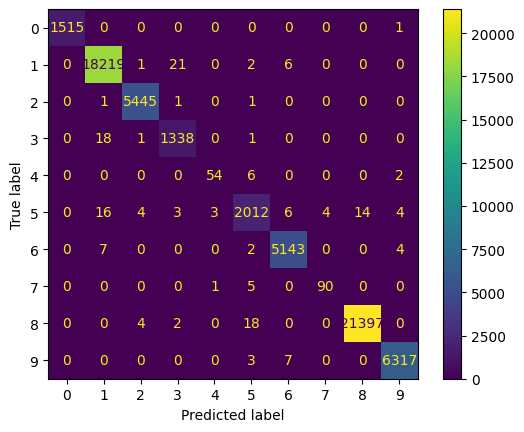

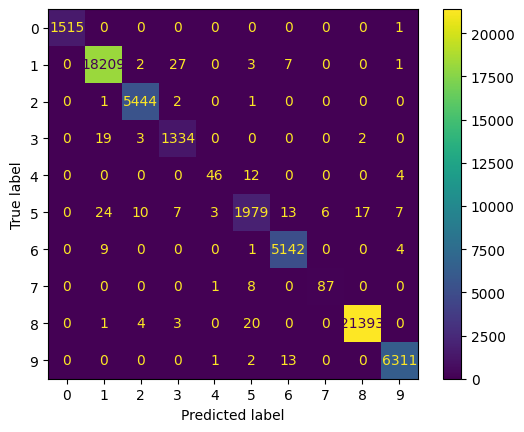

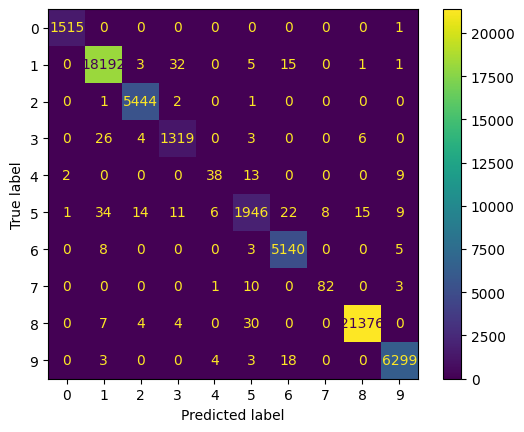

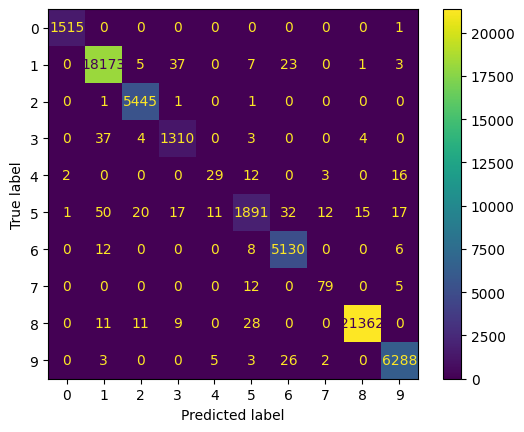

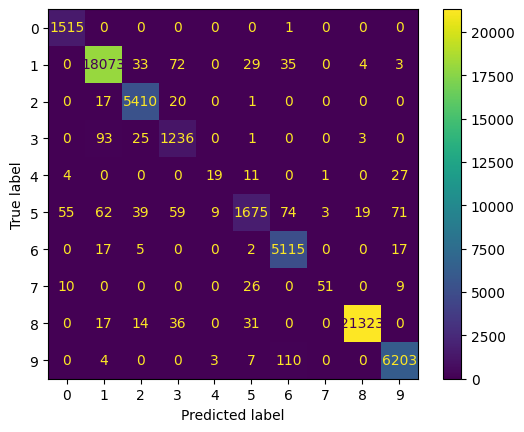

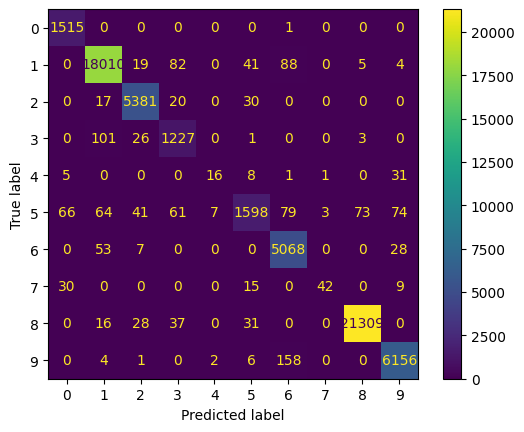

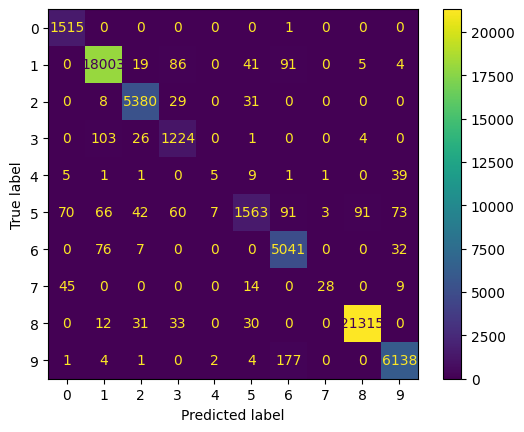

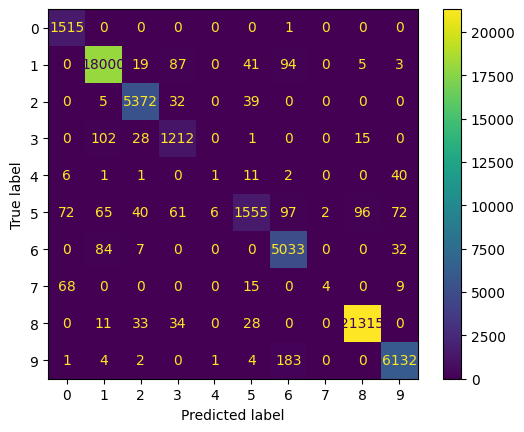

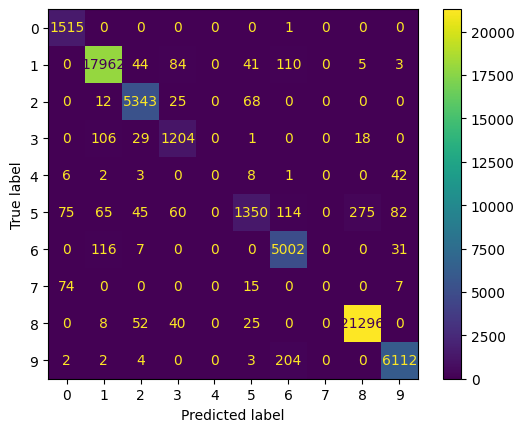

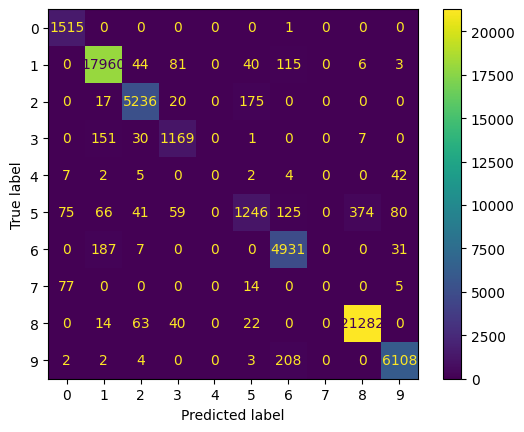

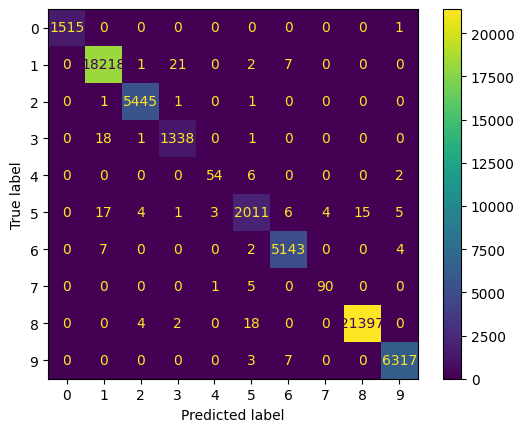

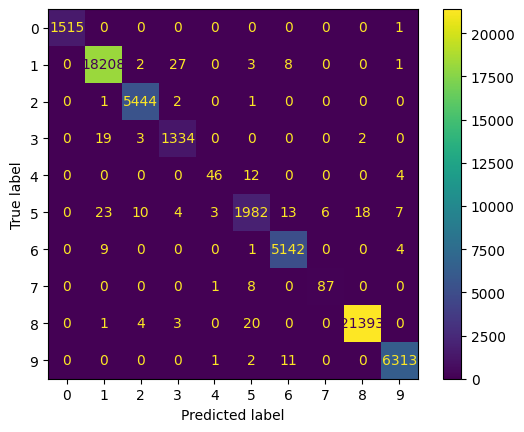

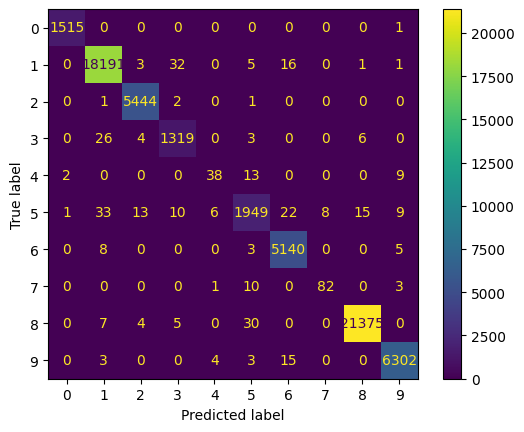

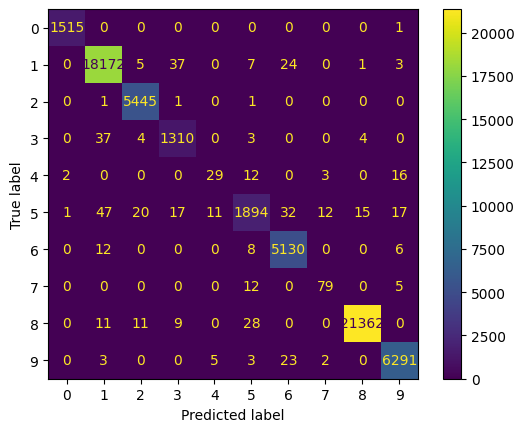

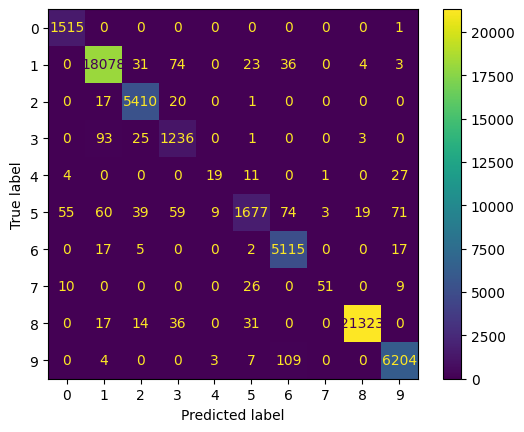

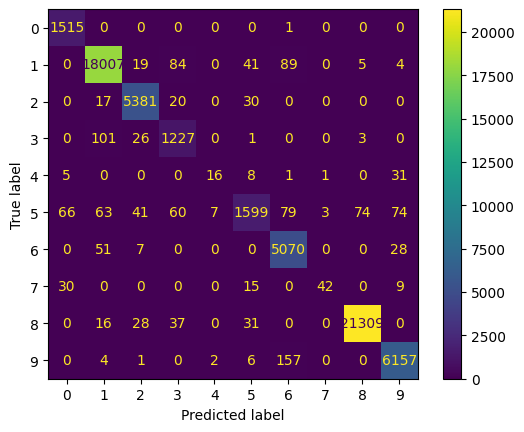

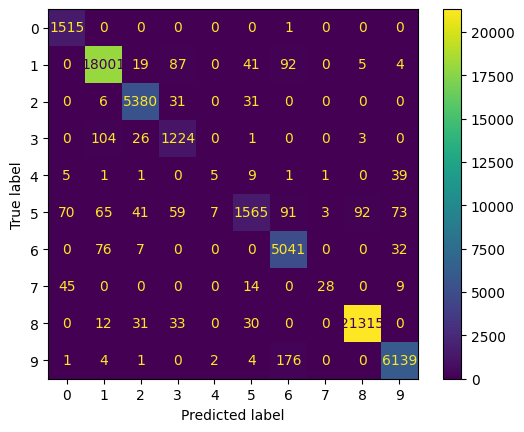

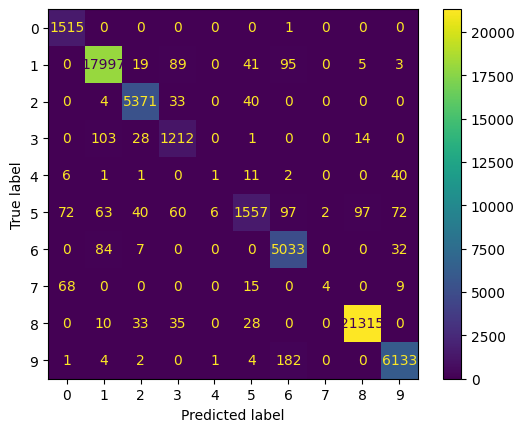

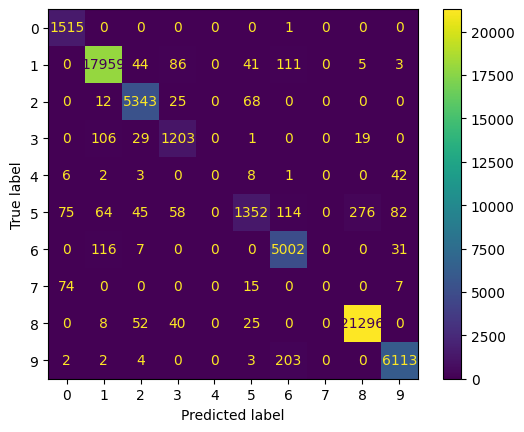

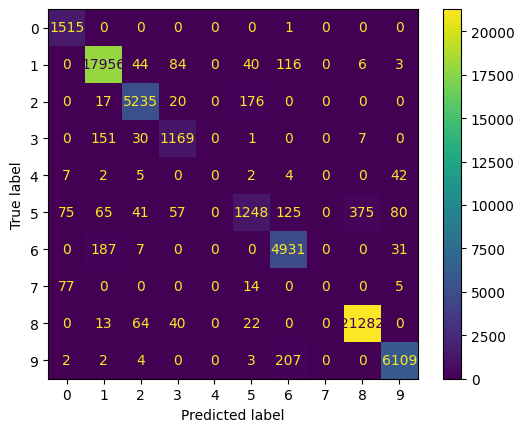

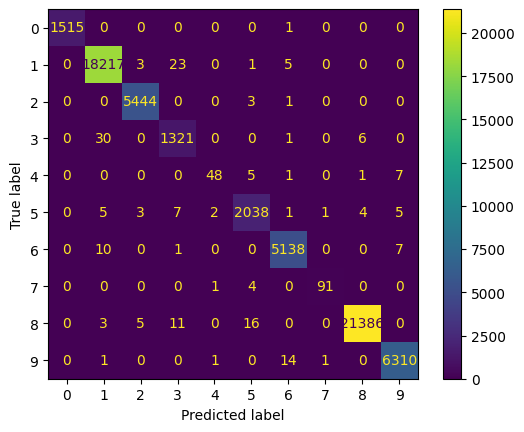

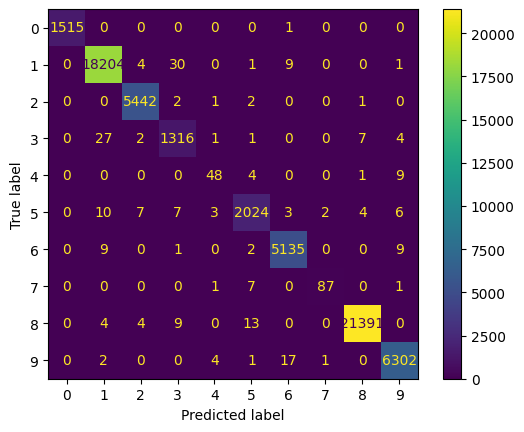

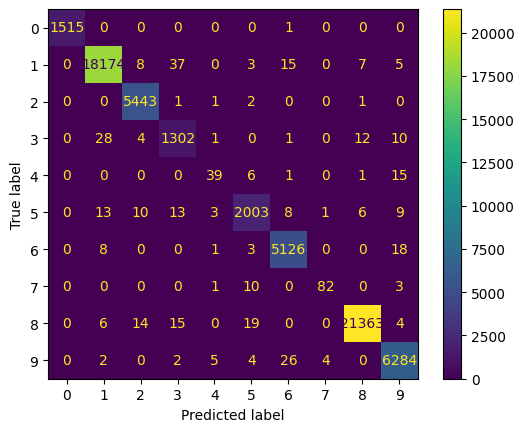

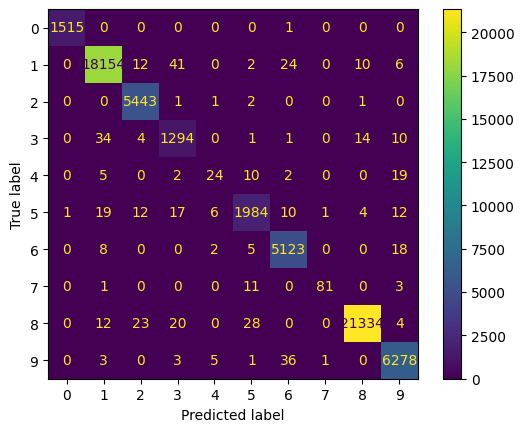

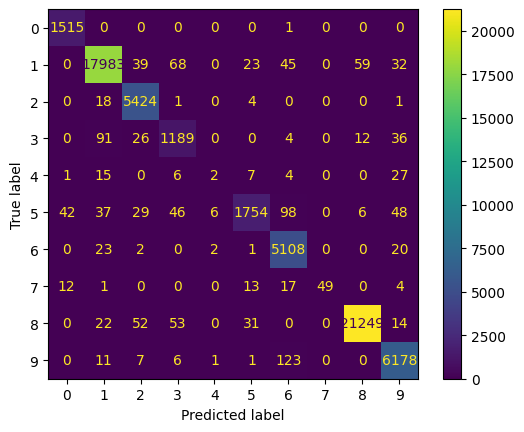

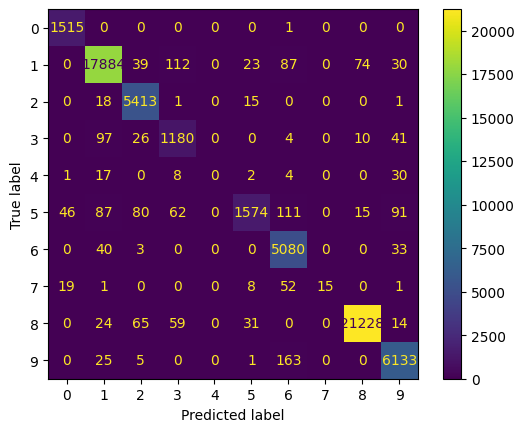

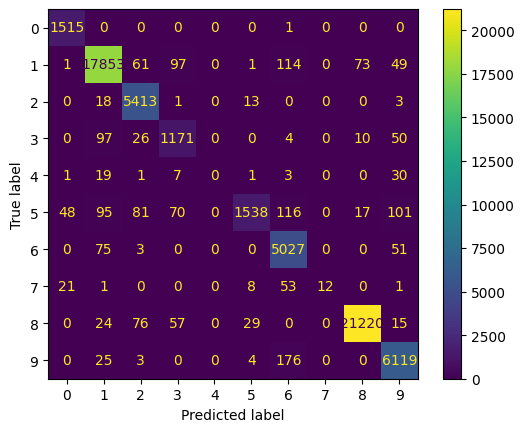

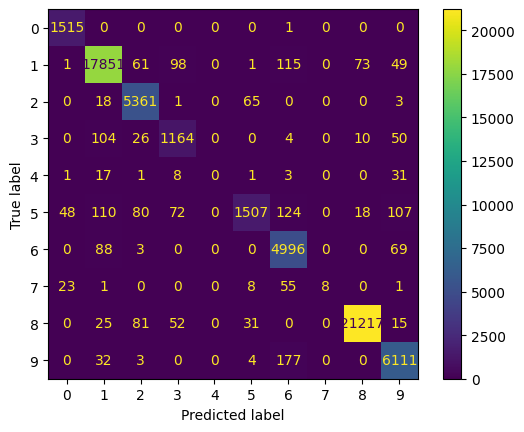

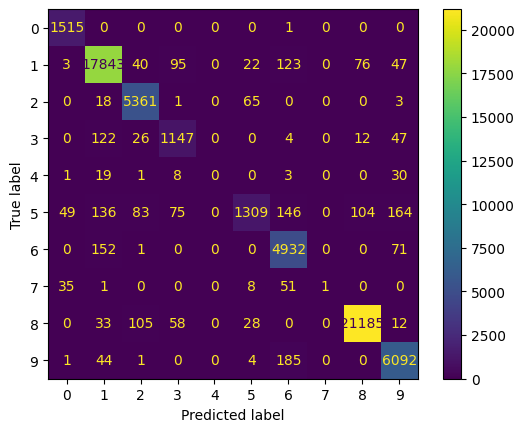

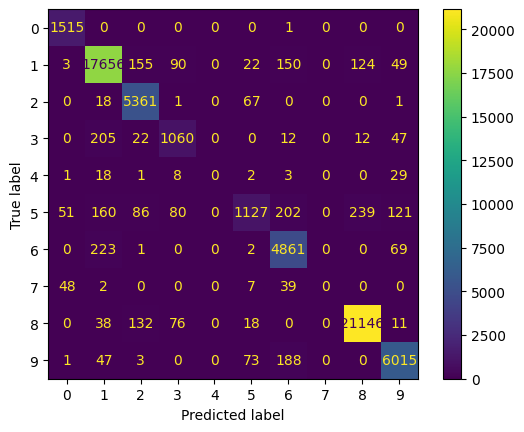

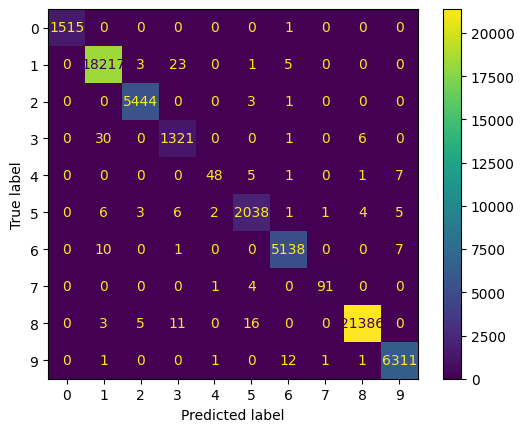

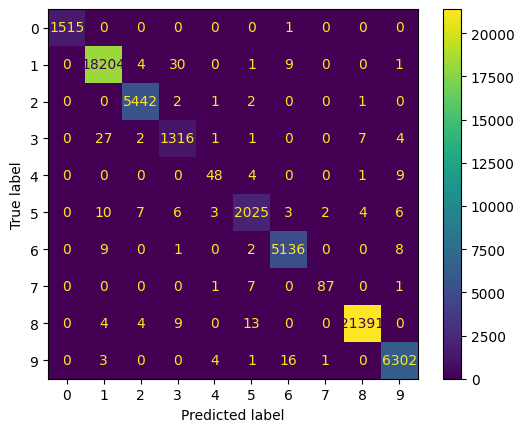

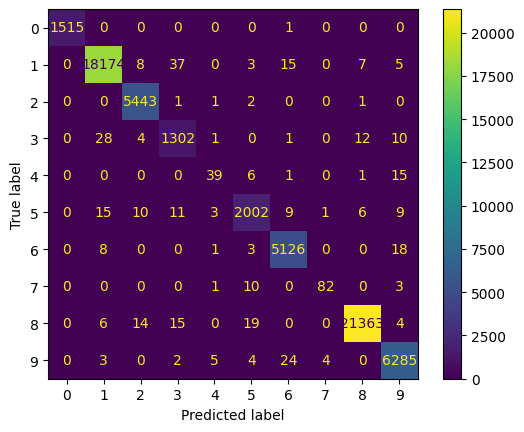

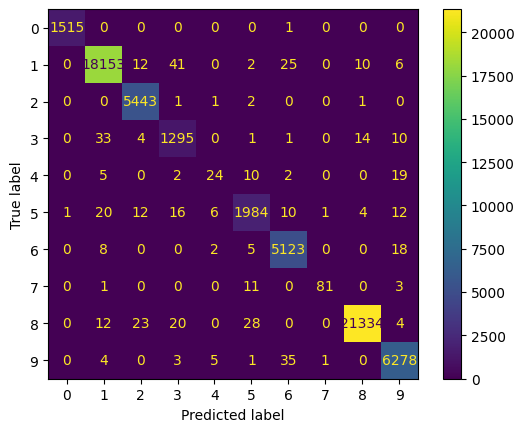

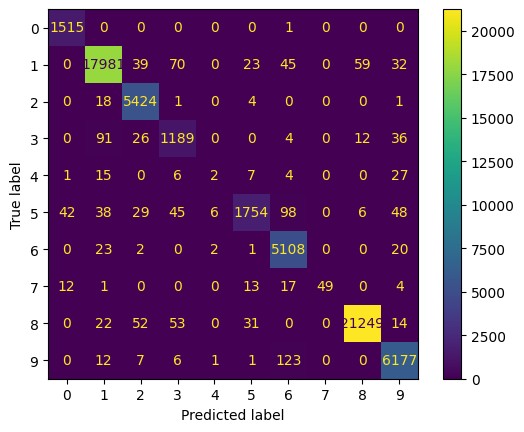

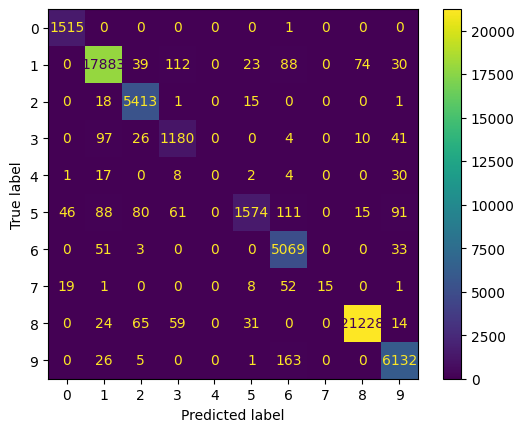

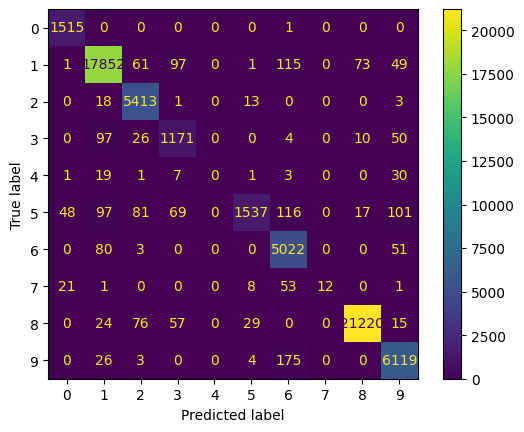

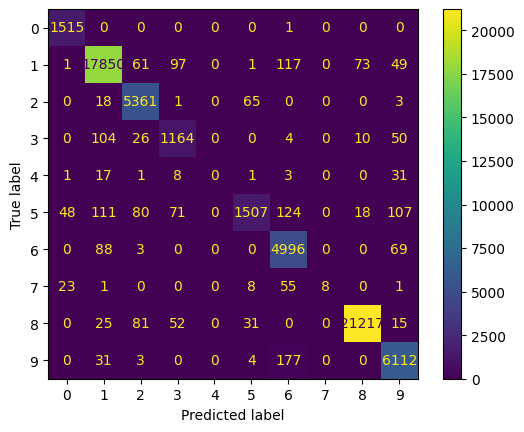

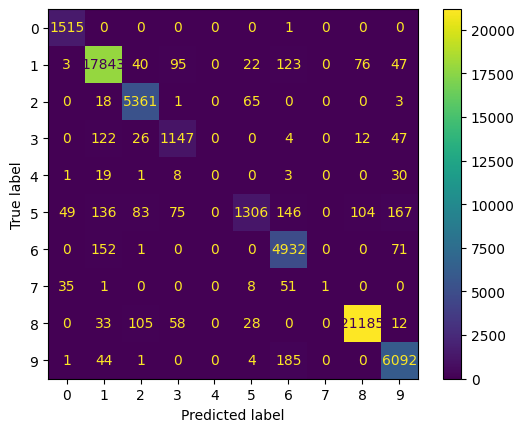

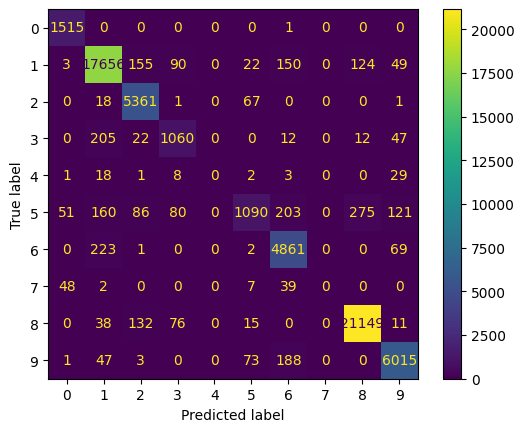

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for i in range(6):
    y_pred_arr = df_y_pred_val.iloc[i]
    for j in range(10):
        tmp = y_pred_arr.iloc[j]
        cm = confusion_matrix(y_val, tmp)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
        disp.plot()

In [93]:
print(df1.shape)
df1.duplicated().sum()

(617002, 46)


np.int64(0)

In [3]:
from sklearn.metrics import precision_score
from sklearn.neighbors import KNeighborsClassifier

In [20]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(precision_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='macro'))
print(precision_score(y_test, y_pred, average='micro'))

y_pred_val = clf.predict(X_val)
print(precision_score(y_val, y_pred_val, average='weighted'))
print(precision_score(y_val, y_pred_val, average='macro'))
print(precision_score(y_val, y_pred_val, average='micro'))


0.9970042178562328
0.979006392278307
0.9970015235501961
0.997253790258521
0.977389807173985
0.9972608956385031


In [21]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train_mod_pca, y_train)
y_pred = clf.predict(X_test_mod_pca)
print(precision_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='macro'))
print(precision_score(y_test, y_pred, average='micro'))

y_pred_val = clf.predict(X_val_mod_pca)
print(precision_score(y_val, y_pred_val, average='weighted'))
print(precision_score(y_val, y_pred_val, average='macro'))
print(precision_score(y_val, y_pred_val, average='micro'))


0.9960852333073242
0.981413663242995
0.9961100846056599
0.9958545804912549
0.9740505421744139
0.9958670318805816


In [22]:
print(precision_score(y_test, y_pred, average=None))

[0.9993395  0.99573887 0.99634035 0.98813056 0.89655172 0.98301698
 0.99361208 0.96703297 0.99911294 0.99526066]


In [23]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train_mod, y_train)
y_pred = clf.predict(X_test_mod)
print(precision_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='macro'))
print(precision_score(y_test, y_pred, average='micro'))

y_pred_val = clf.predict(X_val_mod)
print(precision_score(y_val, y_pred_val, average='weighted'))
print(precision_score(y_val, y_pred_val, average='macro'))
print(precision_score(y_val, y_pred_val, average='micro'))

0.9960852333073242
0.981413663242995
0.9961100846056599
0.9958545804912549
0.9740505421744139
0.9958670318805816


In [ ]:
# Compare rows of X_train and X_test
equal_rows = np.all(X_train[:, None] == X_test, axis=-1).any(axis=1)

# Count the number of equal rows
num_equal_rows = np.sum(equal_rows)

print(f"Number of equal rows between X_train and X_test: {num_equal_rows}")